In [141]:
import polars as pl
import os
from tqdm import tqdm
import pandas as pd
import csv
import numpy as np
import json
import seaborn as sns
import glob
from plotnine import ggplot, geom_boxplot, aes, facet_wrap, theme, element_text, element_blank, theme_minimal, coord_flip, facet_grid
import matplotlib.pyplot as plt
import plotnine

In [125]:
overall_results = glob.glob('results/*_overall.csv')
overall_results[0].split('/')[-1]

'OpenAI_gpt-4-1106-preview_fatal-prompt-v2_pharmexpert-v1_temp0_train_run3_lenient_overall.csv'

In [126]:
all_data = []
for label in tqdm(overall_results):
    [api_source, llm_model, prompt, system, temp, dataset, run, eval_method] = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
    relevant_info = label.split('/')[-1].split('_')
    if relevant_info[0] == 'deepcadrme': # ['deepcadrme', 'test', 'strict', 'overall']
        [llm_model, dataset, eval_method] = relevant_info[0:3]
        basename = llm_model
    elif relevant_info[0] == 'exact': # ['exact', 'train', 'lenient', 'overall']
        [llm_model, dataset, eval_method] = relevant_info[0:3]
        basename = '_'.join([llm_model])
    elif relevant_info[0] == 'code-llama-34b': #['code-llama-34b', 'fatal-prompt-v2', 'pharmexpert-v1', 'temp0', 'train', 'run0', 'strict']
        [llm_model, prompt, system_prompt, temp, dataset, run, eval_method] = relevant_info[:-1]
        basename = '_'.join([llm_model, prompt, system_prompt])
    else: # ['OpenAI', 'gpt-4-1106-preview', 'fatal-prompt-v2', 'pharmexpert-v1', 'temp0', 'train', 'run3', 'lenient', 'overall.csv']
        [api_source, llm_model, prompt, system, temp, dataset, run, eval_method] = relevant_info[:-1]
        basename = '_'.join([llm_model, prompt, system, temp])
    
    with open(label, 'r') as f:
        data = pd.read_csv(f)
        data['api_source'] = api_source
        data['llm_model'] = llm_model
        data['prompt'] = prompt
        data['system'] = system
        data['temp'] = temp
        data['dataset'] = dataset
        data['run'] = run
        data['eval_method'] = eval_method
        data['base_name'] = basename
        all_data.append(data)

overall_results = pd.concat(all_data, axis=0, ignore_index=True)

100%|██████████| 56/56 [00:00<00:00, 208.83it/s]


In [122]:
overall_results.head()

,Unnamed: 0,section,ade_type,tp,fp,fn,micro_precision,micro_recall,micro_f1,macro_precision,...,macro_f1,api_source,llm_model,prompt,system,temp,dataset,run,eval_method,base_name
0,0,adverse reactions,all,4484.0,188.0,853.0,0.95976,0.840172,0.895994,0.951563,...,0.906807,OpenAI,gpt-4-1106-preview,fatal-prompt-v2,pharmexpert-v1,temp0,train,run3,lenient,gpt-4-1106-preview_fatal-prompt-v2_pharmexpert...
1,1,adverse reactions,discontinuous,195.0,NaN,193.0,NaN,0.502577,NaN,NaN,...,NaN,OpenAI,gpt-4-1106-preview,fatal-prompt-v2,pharmexpert-v1,temp0,train,run3,lenient,gpt-4-1106-preview_fatal-prompt-v2_pharmexpert...
2,2,adverse reactions,exact-meddra,3768.0,NaN,395.0,NaN,0.905117,NaN,NaN,...,NaN,OpenAI,gpt-4-1106-preview,fatal-prompt-v2,pharmexpert-v1,temp0,train,run3,lenient,gpt-4-1106-preview_fatal-prompt-v2_pharmexpert...
3,3,adverse reactions,negated,24.0,NaN,8.0,NaN,0.750000,NaN,NaN,...,NaN,OpenAI,gpt-4-1106-preview,fatal-prompt-v2,pharmexpert-v1,temp0,train,run3,lenient,gpt-4-1106-preview_fatal-prompt-v2_pharmexpert...
4,4,adverse reactions,non-meddra,717.0,NaN,458.0,NaN,0.610213,NaN,NaN,...,NaN,OpenAI,gpt-4-1106-preview,fatal-prompt-v2,pharmexpert-v1,temp0,train,run3,lenient,gpt-4-1106-preview_fatal-prompt-v2_pharmexpert...


In [135]:
overall_data = pd.melt(overall_results, id_vars = ['api_source', 'llm_model', 'section', 'ade_type', 'prompt', 'system',
                                                    'temp', 'dataset', 'run', 'eval_method',
                                                    'base_name'],
         value_vars = ['macro_f1',	'macro_precision',	'macro_recall',	'micro_f1',	'micro_precision',	'micro_recall'],
           var_name = 'metric', value_name = 'score')
overall_data[['level','metric']] = overall_data['metric'].str.split('_',expand=True)
overall_data.head()

,api_source,llm_model,section,ade_type,prompt,system,temp,dataset,run,eval_method,base_name,metric,score,level
0,OpenAI,gpt-4-1106-preview,adverse reactions,all,fatal-prompt-v2,pharmexpert-v1,temp0,train,run3,lenient,gpt-4-1106-preview_fatal-prompt-v2_pharmexpert...,f1,0.906807,macro
1,OpenAI,gpt-4-1106-preview,adverse reactions,discontinuous,fatal-prompt-v2,pharmexpert-v1,temp0,train,run3,lenient,gpt-4-1106-preview_fatal-prompt-v2_pharmexpert...,f1,NaN,macro
2,OpenAI,gpt-4-1106-preview,adverse reactions,exact-meddra,fatal-prompt-v2,pharmexpert-v1,temp0,train,run3,lenient,gpt-4-1106-preview_fatal-prompt-v2_pharmexpert...,f1,NaN,macro
3,OpenAI,gpt-4-1106-preview,adverse reactions,negated,fatal-prompt-v2,pharmexpert-v1,temp0,train,run3,lenient,gpt-4-1106-preview_fatal-prompt-v2_pharmexpert...,f1,NaN,macro
4,OpenAI,gpt-4-1106-preview,adverse reactions,non-meddra,fatal-prompt-v2,pharmexpert-v1,temp0,train,run3,lenient,gpt-4-1106-preview_fatal-prompt-v2_pharmexpert...,f1,NaN,macro


## Plotting Overall Performance

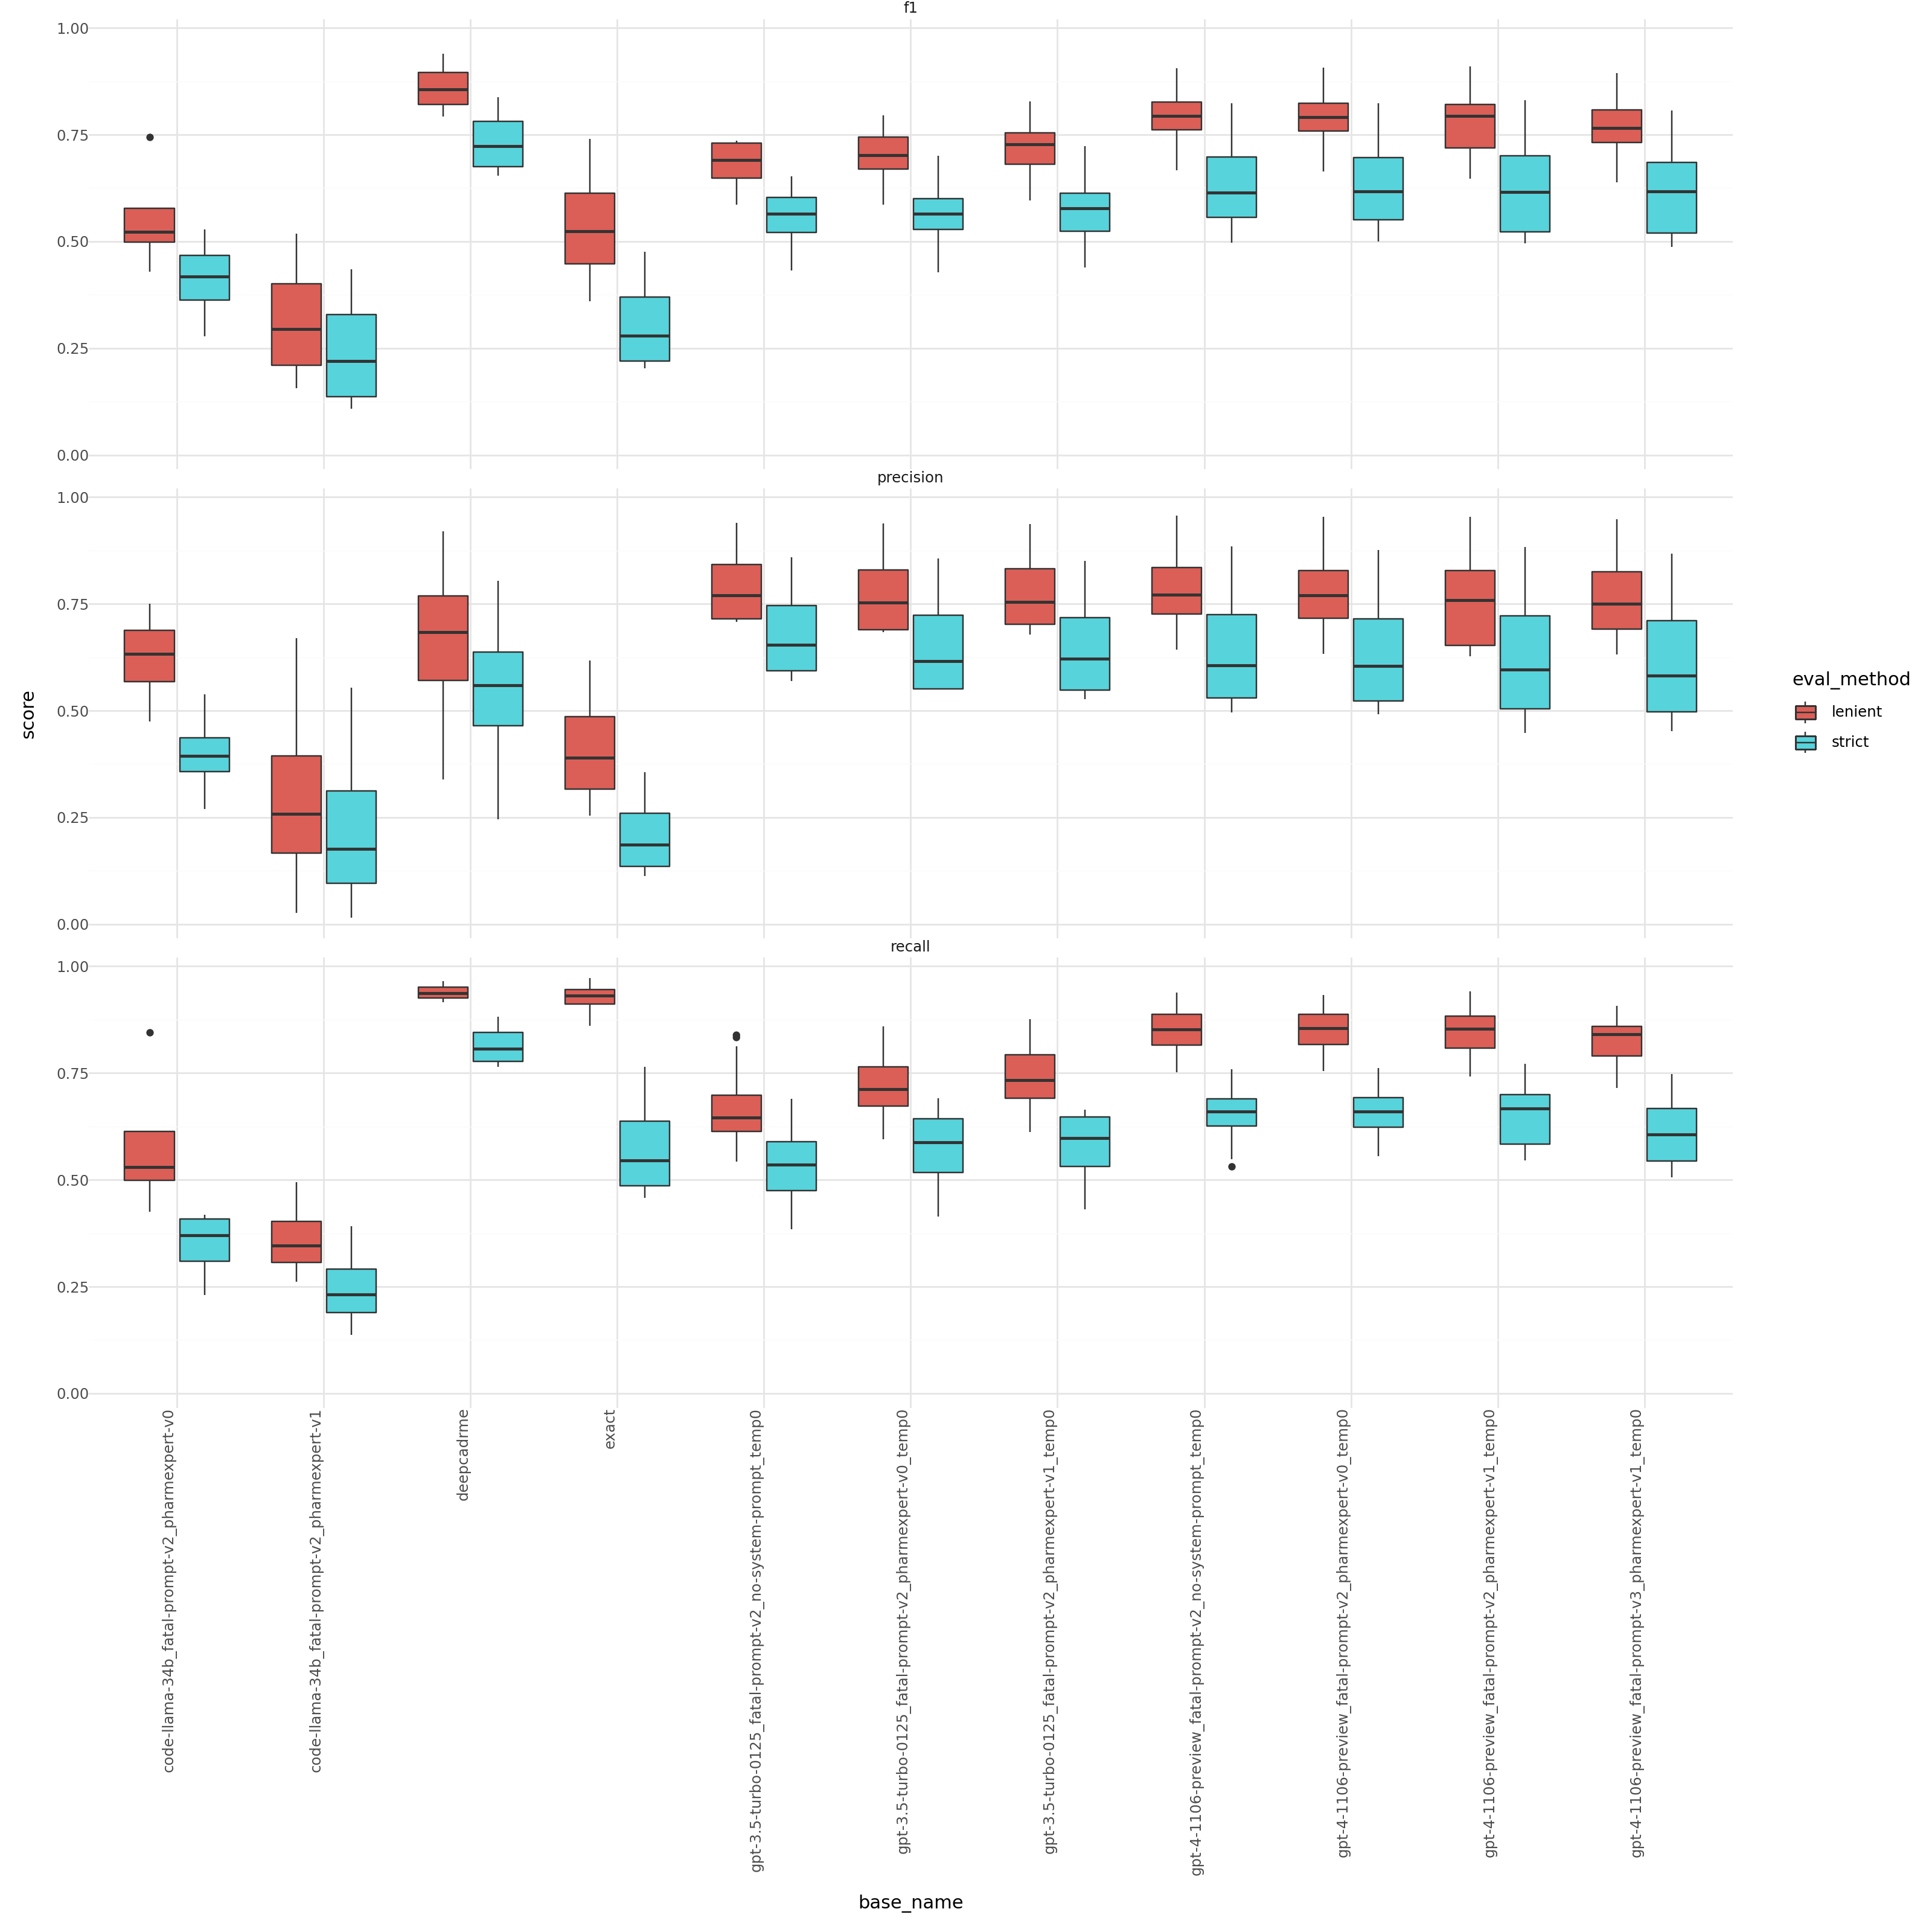

In [149]:
plotnine.options.figure_size = (16, 16) 

(
    ggplot(overall_data.query('ade_type == "all" & level == "macro"'),
           aes(x = 'base_name', y = 'score', fill = 'eval_method')) +
        geom_point() +
        theme_minimal() +
        theme(axis_text_x = element_text(angle = 90, hjust = 1)) +
        facet_wrap('~metric', ncol = 1)
)